In [196]:
import cv2
import numpy as np
import pandas as pd
# from PIL import Image
# from skimage.transform import resize
from matplotlib import pyplot as plt
import torch

In [112]:
imgList = []
data = pd.read_csv('./training.csv')
filename = '640x480-val-32-12022019-154657-testOutputs'
# data = pd.read_csv('./submission/'+filename+'.csv')

In [113]:
data.shape

(14000, 5)

In [114]:
for i in data:
    print i

image_name
x1
x2
y1
y2


In [115]:
data.iloc[0][2]

495

In [6]:
sourcePath = './training_images/'
# savePath = './ground_truth/training_images/'
import os

# sourcePath = './test_images/'
savePath = './submission_visuals_'+filename+'/'
# savePath = './rough/'

if not os.path.exists(savePath):
    os.makedirs(savePath)
    


In [83]:
num_eg = 2
eg = [13]

In [186]:
def show(img, imgX1, imgX2, imgY1, imgY2):
    imgTemp = img.copy()
    cv2.rectangle(imgTemp,(imgX1,imgY1),(imgX2,imgY2),(0,255,0),2)
    plt.imshow(imgTemp)
    plt.show()

In [ ]:
type(img)

In [266]:
'''
most of func in opencv accept args as (width, height)
but img.shape gives (height, width)
height = Y axis = #cols
width = X axis = #rows
'''
def horizontalFlip(img, imgX1, imgX2, imgY1, imgY2):
    imgTemp = img.copy()
    imgHeight, imgWidth, _ = imgTemp.shape
    imgTemp = cv2.flip(imgTemp, 1)
    imgX1 = imgWidth - imgX1
    imgX2 = imgWidth - imgX2 
    imgY1 = imgY1
    imgY2 = imgY2
    
    return imgTemp, imgX1, imgX2, imgY1, imgY2

def verticalFlip(img, imgX1, imgX2, imgY1, imgY2):
    imgTemp = img.copy()
    imgHeight, imgWidth, _ = imgTemp.shape
    imgTemp = cv2.flip(imgTemp, 0)
    imgX1 = imgX1
    imgX2 = imgX2 
    imgY1 = imgHeight - imgY1
    imgY2 = imgHeight - imgY2
    
    return imgTemp, imgX1, imgX2, imgY1, imgY2

def backDiagonalFlip(img, imgX1, imgX2, imgY1, imgY2):

    imgHeight, imgWidth, _ = img.shape
    assert imgHeight==imgWidth, "Diagonal Flips only allowed for square inputs ie: height==width"

    imgTemp = img.copy()
    print(imgHeight, imgWidth)
    
    for i in range(0, imgHeight):
        for j in range(0, i):
            temp = imgTemp[i][j].copy()
            imgTemp[i][j] = imgTemp[j][i]
            imgTemp[j][i] = temp
            
    temp = imgX1
    imgX1 = imgY1
    imgY1 = temp
    
    temp = imgX2
    imgX2 = imgY2 
    imgY2 = temp
    
    return imgTemp, imgX1, imgX2, imgY1, imgY2

def frontDiagonalFlip(img, imgX1, imgX2, imgY1, imgY2):

    imgHeight, imgWidth, _ = img.shape
    assert imgHeight==imgWidth, "Diagonal Flips only allowed for square inputs ie: height==width"

    imgTemp = img.copy()
    print(imgHeight, imgWidth)
    
    for i in range(0, imgHeight):
        for j in range(0, imgHeight-i):
            temp = imgTemp[i][j].copy()
            imgTemp[i][j] = imgTemp[imgHeight-j-1][imgHeight-i-1]
            imgTemp[imgHeight-j-1][imgHeight-i-1] = temp
            
    temp = imgX1
    imgX1 = imgHeight - imgY1
    imgY1 = imgHeight - temp
    
    temp = imgX2
    imgX2 = imgHeight - imgY2 
    imgY2 = imgHeight - temp
    
    return imgTemp, imgX1, imgX2, imgY1, imgY2

def scale(img, imgNewWidth, imgNewHeight, imgX1, imgX2, imgY1, imgY2, interpolation=cv2.INTER_LINEAR):
#     print(imgX1, imgX2, imgY1, imgY2)
    
    imgTemp = img.copy()
    imgHeight, imgWidth, _ = imgTemp.shape
#     print(imgHeight, imgWidth)
    
    imgTemp = cv2.resize(imgTemp, (imgNewWidth, imgNewHeight), interpolation=interpolation)
    
    fY = float(imgNewHeight)/float(imgHeight)
    fX = float(imgNewWidth)/float(imgWidth)
    
    imgX1 = max(0, int(imgX1*fX))
    imgX2 = min(int(imgX2*fX), imgNewWidth)
    imgY1 = max(0, int(imgY1*fY))
    imgY2 = min(int(imgY2*fY), imgNewHeight)
    
#     print(imgX1, imgX2, imgY1, imgY2)
#     print("fX:", fX, " fY:", fY)
    
    return imgTemp, imgX1, imgX2, imgY1, imgY2

def translate(img, widthShift, heightShift, imgX1, imgX2, imgY1, imgY2):
    
    imgTemp = img.copy()
    imgHeight, imgWidth, _ = imgTemp.shape

    M = np.float32([[1, 0, widthShift], [0, 1, heightShift]])
    imgTemp = cv2.warpAffine(imgTemp, M, (imgWidth, imgHeight))
    
    imgX1 = min(imgX1+widthShift, imgWidth)
    imgX2 = min(imgX2+widthShift, imgWidth)
    
    imgY1 = min(imgY1+heightShift, imgHeight)
    imgY2 = min(imgY2+heightShift, imgHeight)
    
    
    return imgTemp, imgX1, imgX2, imgY1, imgY2

def rotate(img, center, angle, scale, imgX1, imgX2, imgY1, imgY2):
    
    '''
    (imgX1, imgY1)----------(imgXb, imgYb)
           |                       |
           |                       |
           |                       |
           |                       |
    (imgXa, imgYa)---------(imgX2, imgY2)
    '''
    
    imgTemp = img.copy()
    imgHeight, imgWidth, _ = imgTemp.shape

    M = cv2.getRotationMatrix2D(center, angle, scale)
    imgTemp = cv2.warpAffine(imgTemp, M, (imgWidth, imgHeight))
    
    imgXa = imgX1
    imgYa = imgY2
    imgXb = imgX2
    imgYb = imgY1
    
#     print("X", imgX1, imgXa, imgXb, imgX2)
#     print("Y", imgY1, imgYa, imgYb, imgY2)
    
    imgX1Temp = M[0][0]*imgX1 + M[0][1]*imgY1 + M[0][2]
    imgY1Temp = M[1][0]*imgX1 + M[1][1]*imgY1 + M[1][2]
    
    imgXaTemp = M[0][0]*imgXa + M[0][1]*imgYa + M[0][2]
    imgYaTemp = M[1][0]*imgXa + M[1][1]*imgYa + M[1][2]
    
    imgXbTemp = M[0][0]*imgXb + M[0][1]*imgYb + M[0][2]
    imgYbTemp = M[1][0]*imgXb + M[1][1]*imgYb + M[1][2]
    
    imgX2Temp = M[0][0]*imgX2 + M[0][1]*imgY2 + M[0][2]
    imgY2Temp = M[1][0]*imgX2 + M[1][1]*imgY2 + M[1][2]
    
#     print("X", imgX1Temp, imgXaTemp, imgXbTemp, imgX2Temp)
#     print("Y", imgY1Temp, imgYaTemp, imgYbTemp, imgY2Temp)
    
    imgX1 = int(round(max(0, min(min(min(min(imgX1Temp, imgWidth), imgXaTemp), imgXbTemp), imgX2Temp) )))
    imgX2 = int(round(min(max(max(max(max(imgX1Temp, 0), imgXaTemp), imgXbTemp), imgX2Temp), imgWidth)))
    imgY1 = int(round(max(0, min(min(min(min(imgY1Temp, imgHeight), imgYaTemp), imgYbTemp), imgY2Temp) )))
    imgY2 = int(round(min(max(max(max(max(imgY1Temp, 0), imgYaTemp), imgYbTemp), imgY2Temp), imgHeight)))
    
#     print(M)
#     print(imgX1, imgX2, imgY1, imgY2)
    
    
    return imgTemp, imgX1, imgX2, imgY1, imgY2


def rotate(img, center, angle, scale, imgX1, imgX2, imgY1, imgY2):
    
    '''
    (imgX1, imgY1)----------(imgXb, imgYb)
           |                       |
           |                       |
           |                       |
           |                       |
    (imgXa, imgYa)---------(imgX2, imgY2)
    '''
    
    imgTemp = img.copy()
    imgHeight, imgWidth, _ = imgTemp.shape

    M = cv2.getRotationMatrix2D(center, angle, scale)
    imgTemp = cv2.warpAffine(imgTemp, M, (imgWidth, imgHeight))
    
    imgXa = imgX1
    imgYa = imgY2
    imgXb = imgX2
    imgYb = imgY1
    
#     print("X", imgX1, imgXa, imgXb, imgX2)
#     print("Y", imgY1, imgYa, imgYb, imgY2)
    
    imgX1Temp = M[0][0]*imgX1 + M[0][1]*imgY1 + M[0][2]
    imgY1Temp = M[1][0]*imgX1 + M[1][1]*imgY1 + M[1][2]
    
    imgXaTemp = M[0][0]*imgXa + M[0][1]*imgYa + M[0][2]
    imgYaTemp = M[1][0]*imgXa + M[1][1]*imgYa + M[1][2]
    
    imgXbTemp = M[0][0]*imgXb + M[0][1]*imgYb + M[0][2]
    imgYbTemp = M[1][0]*imgXb + M[1][1]*imgYb + M[1][2]
    
    imgX2Temp = M[0][0]*imgX2 + M[0][1]*imgY2 + M[0][2]
    imgY2Temp = M[1][0]*imgX2 + M[1][1]*imgY2 + M[1][2]
    
#     print("X", imgX1Temp, imgXaTemp, imgXbTemp, imgX2Temp)
#     print("Y", imgY1Temp, imgYaTemp, imgYbTemp, imgY2Temp)
    
    imgX1 = int(round(max(0, min(min(min(min(imgX1Temp, imgWidth), imgXaTemp), imgXbTemp), imgX2Temp) )))
    imgX2 = int(round(min(max(max(max(max(imgX1Temp, 0), imgXaTemp), imgXbTemp), imgX2Temp), imgWidth)))
    imgY1 = int(round(max(0, min(min(min(min(imgY1Temp, imgHeight), imgYaTemp), imgYbTemp), imgY2Temp) )))
    imgY2 = int(round(min(max(max(max(max(imgY1Temp, 0), imgYaTemp), imgYbTemp), imgY2Temp), imgHeight)))
    
#     print(M)
#     print(imgX1, imgX2, imgY1, imgY2)
    
    
    return imgTemp, imgX1, imgX2, imgY1, imgY2


In [267]:
img.shape

(480, 640, 3)

scale


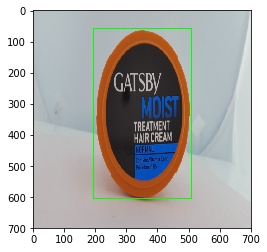

rotate
('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', 190.58490190266409, 333.06323167838048, 652.95214194189577, 795.43047171761214)
('Y', -56.892286555535151, 751.14247479098151, -138.42010597015894, 669.61465537635763)
[[   1.47721163    0.26047227 -112.83922958]
 [  -0.26047227    1.47721163  -93.25568073]]
(191, 700, 0, 700)


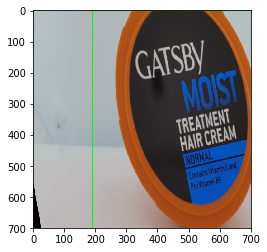

('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', 135.91742739918789, 416.54495499789914, 577.10311285817181, 857.73064045688307)
('Y', -67.959806279070563, 703.0579890757673, -228.53826357047203, 542.4795317843658)
[[   1.40953893    0.51303021 -169.21144687]
 [  -0.51303021    1.40953893  -51.0817113 ]]
(136, 700, 0, 700)


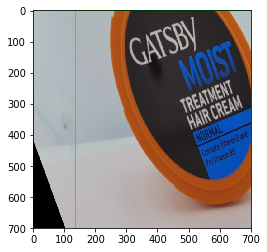

('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', 80.158620039282511, 490.40862003928248, 486.75754711607647, 897.00754711607635)
('Y', -69.366278184241665, 641.20756562089014, -304.11627818424159, 406.45756562089025)
[[   1.29903811    0.75       -217.40381057]
 [  -0.75          1.29903811    0.24047358]]
(80, 700, 0, 641)


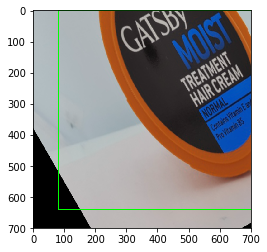

('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', 25.00268296926086, 552.40991671706627, 384.66054901362111, 912.06778276142666)
('Y', -61.068967333919048, 567.47049824520241, -362.85775008174926, 265.68171549737224)
[[   1.14906666    0.96418141 -255.9520201 ]
 [  -0.96418141    1.14906666   59.15147528]]
(25, 700, 0, 567)


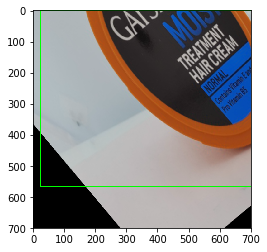

('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', -27.874498573255352, 600.66496700586617, 273.9142841745749, 902.45374975369646)
('Y', -43.319983319647932, 484.08725042815769, -402.97784936400819, 124.42938438379748)
[[   0.96418141    1.14906666 -283.68480762]
 [  -1.14906666    0.96418141  123.86131284]]
(0, 700, 0, 484)


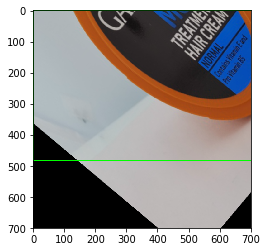

('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', -76.866278184241622, 633.70756562089014, 157.88372181575841, 868.45756562089036)
('Y', -16.658620039282539, 393.59137996071752, -423.25754711607652, -13.00754711607641)
[[   0.75          1.29903811 -299.75952642]
 [  -1.29903811    0.75        192.40381057]]
(0, 700, 0, 394)


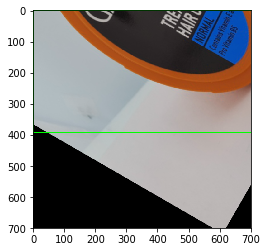

('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', -120.48406543125495, 650.53372992358277, 40.094391860146573, 811.11218721498437)
('Y', 18.105030475204018, 298.7325580739153, -423.08065498377994, -142.45312738506863)
[[   0.51303021    1.40953893 -303.68775429]
 [  -1.40953893    0.51303021  262.69633937]]
(0, 700, 0, 299)


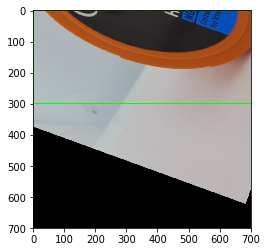

('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', -157.40255592046006, 650.63220542605654, -75.874736505836211, 732.16002484068042)
('Y', 59.914692294184761, 202.39302206990118, -402.4525477450469, -259.97421796933043)
[[  2.60472267e-01   1.47721163e+00  -2.95350134e+02]
 [ -1.47721163e+00   2.60472267e-01   3.32603096e+02]]
(0, 700, 0, 202)


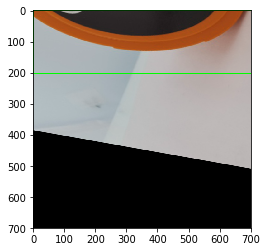

('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', -186.5, 634.0, -186.49999999999994, 634.0)
('Y', 107.5, 107.50000000000006, -362.0, -362.0)
[[  9.18485099e-17   1.50000000e+00  -2.75000000e+02]
 [ -1.50000000e+00   9.18485099e-17   4.00000000e+02]]
(0, 634, 0, 108)


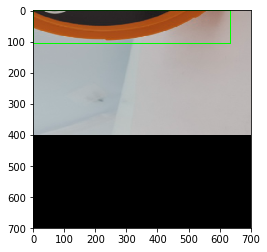

('X', 195, 195, 508, 508)
('Y', 59, 606, 59, 606)
('X', -206.89228655553515, 601.14247479098151, -288.42010597015894, 519.61465537635775)
('Y', 159.41509809733589, 16.936768321619581, -302.95214194189577, -445.43047171761202)
[[ -2.60472267e-01   1.47721163e+00  -2.43255681e+02]
 [ -1.47721163e+00  -2.60472267e-01   4.62839230e+02]]
(0, 601, 0, 159)


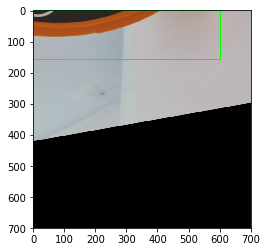

original img:


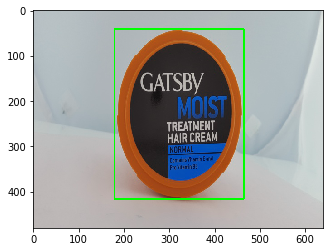

In [271]:
# for i in range(0, len(data)):
# for i in range(0, num_eg):
for i in eg:
    imgName = data.iloc[i][0]
    # img = cv2.imread(sourcePath+'14581478747652.png')
    img = cv2.imread(sourcePath+data.iloc[i][0])

    imgX1 = data.iloc[i][1]
    imgX2 = data.iloc[i][2]
    imgY1 = data.iloc[i][3]
    imgY2 = data.iloc[i][4]

#     verticalFlip(img, imgX1, imgX2, imgY1, imgY2)
#     print("horizontal")
#     img2, imgX12, imgX22, imgY12, imgY22 = horizontalFlip(img, imgX1, imgX2, imgY1, imgY2)
#     show(img2, imgX12, imgX22, imgY12, imgY22)
    
#     print("vertical")
#     img3, imgX13, imgX23, imgY13, imgY23 = verticalFlip(img, imgX1, imgX2, imgY1, imgY2)
#     show(img3, imgX13, imgX23, imgY13, imgY23)
    
    print("scale")
    img4, imgX14, imgX24, imgY14, imgY24 = scale(img, 700, 700, imgX1, imgX2, imgY1, imgY2)
    show(img4, imgX14, imgX24, imgY14, imgY24)
    
#     print("backDiagonal")
#     img5, imgX15, imgX25, imgY15, imgY25 = backDiagonalFlip(img4, imgX14, imgX24, imgY14, imgY24)
#     show(img5, imgX15, imgX25, imgY15, imgY25)
    
#     print("frontDiagonal")
#     img6, imgX16, imgX26, imgY16, imgY26 = frontDiagonalFlip(img4, imgX14, imgX24, imgY14, imgY24)
#     show(img6, imgX16, imgX26, imgY16, imgY26)
    
#     print("translate")
#     img3, imgX13, imgX23, imgY13, imgY23 = translate(img, 50, 200, imgX1, imgX2, imgY1, imgY2)
#     show(img3, imgX13, imgX23, imgY13, imgY23)
    
    print("rotate")
    for a in (10, 20, 30, 40, 50, 60, 70, 80, 90, 100):
        img3, imgX13, imgX23, imgY13, imgY23 = rotate(img4, (100, 250), a, 1.5, imgX14, imgX24, imgY14, imgY24)
        show(img3, imgX13, imgX23, imgY13, imgY23)
    
    
    
    print("original img:")
    show(img, imgX1, imgX2, imgY1, imgY2)
    
    # cv2.rectangle(img,(10,10),(100,100),(0,255,0),2)
#     # cv2.imwrite(savePath+'14581478747652.png', img)
#     cv2.imwrite(savePath+data.iloc[i][0], img)

In [ ]:
# 1468557492774JPEG_20160630_171413_1000409404142

In [ ]:
img = Image.open('./training_images/1457419537031DSC_0002.png').convert('L')
img = img.resize((640, 480), Image.ANTIALIAS)

In [ ]:
np_img = np.array(img)

In [ ]:
np_img.shape

In [ ]:
np.flip(np_img

In [ ]:
plt.imshow(np.flip((np_img), axis=1))
plt.show()